In [16]:
## HW12 - TimeSeriesAnalysis
## Kushal Chandani
### kc07535@st.habib.edu.pk

In [17]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [18]:
#Reading the data
df = pd.read_csv('karachi-weather-2021-2023.csv')
df

,datetime,temp
0,1/1/2021,15.0
1,1/2/2021,15.4
2,1/3/2021,15.6
3,1/4/2021,16.3
4,1/5/2021,17.1
...,...,...
841,4/22/2023,29.5
842,4/23/2023,30.0
843,4/24/2023,30.4
844,4/25/2023,29.9


In [19]:
#Question 1
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.index = pd.to_datetime(df.index)

weekly_mean = df.resample('W').mean()
weekly_mean

,temp
datetime,
2021-01-03,15.333333
2021-01-10,16.028571
2021-01-17,17.085714
2021-01-24,19.457143
2021-01-31,17.800000
...,...
2023-04-02,26.414286
2023-04-09,27.328571
2023-04-16,27.628571


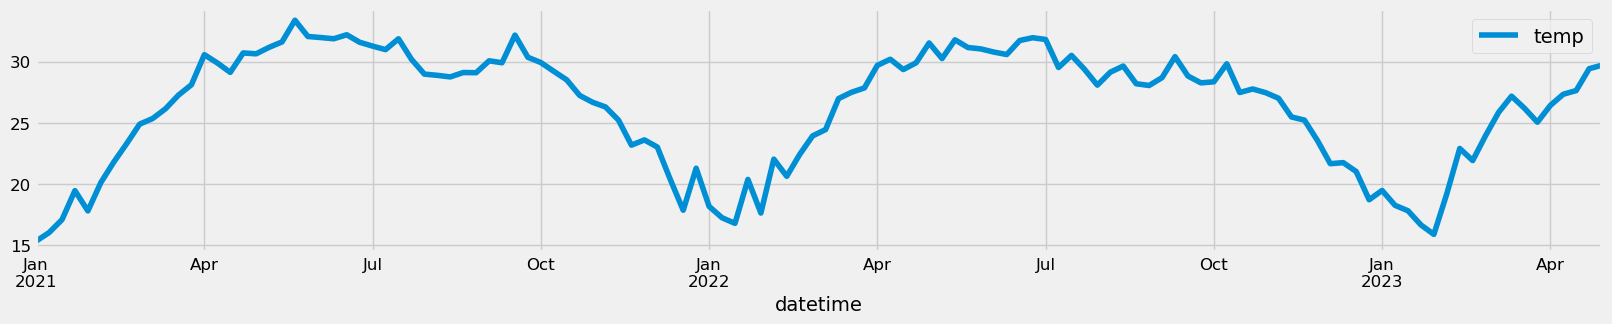

In [20]:
#Question 2

weekly_mean.plot(figsize=(18, 3))
plt.show()

# The provided graph illustrates the average weekly temperature fluctuations in Karachi
# spanning from January 2021 to April 2023.
# Notably, the graph depicts varying peaks and troughs, indicating the dynamic nature
# of Karachi's temperature throughout the months.
# It is evident that the temperature is not constant but undergoes fluctuations.
# January registers the lowest temperature, while May and June consistently record
# the highest temperatures, exceeding 30 degrees Celsius.
# In summary, this plot serves as a valuable tool for observing the temperature trends
# in Karachi from early 2021 to mid-2023.

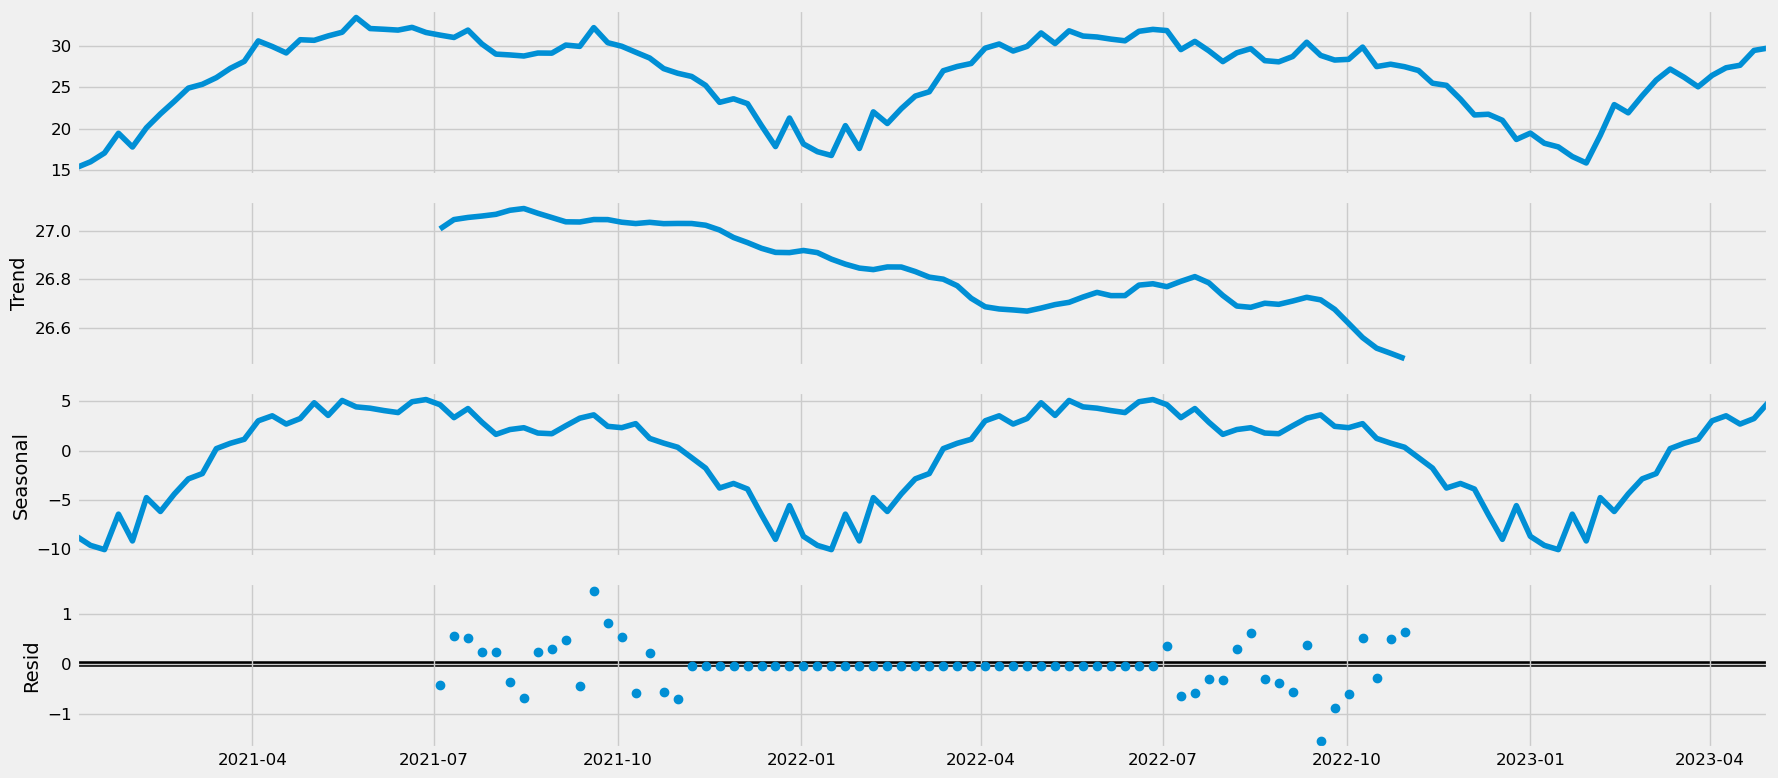

In [21]:
decomposition = sm.tsa.seasonal_decompose(weekly_mean, model='additive')
rcParams['figure.figsize'] = (18, 8)
fig = decomposition.plot()
plt.show()

# The presented plot exhibits three distinct graphs, each portraying a different aspect
# of the decomposition: trend, seasonal, and residual.

# The first graph, depicting the trend component, exclusively showcases the primary trend
# observed in temperature changes, excluding minor fluctuations. It reveals a declining
# trend, indicating a consistent decrease in temperature over time. For instance, there
# is a noticeable dip after October 2022, highlighting a prolonged temperature decrease.

# The second graph represents the seasonal component, illustrating the yearly temperature
# pattern. It suggests that temperatures tend to be higher in the middle of the year and
# cooler at the beginning and end. This pattern is evident in a significant dip in the
# graph during January. Overall, this graph effectively displays the seasonal trend in Karachi.

# The third graph, the residual, illustrates unexplained variations in temperature data
# not accounted for by the trend or seasonal components. It points out instances where
# temperatures deviate significantly from expected patterns, potentially due to external
# factors like weather anomalies or measurement inaccuracies. In essence, this graph
# provides insight into the overall variability in temperature.

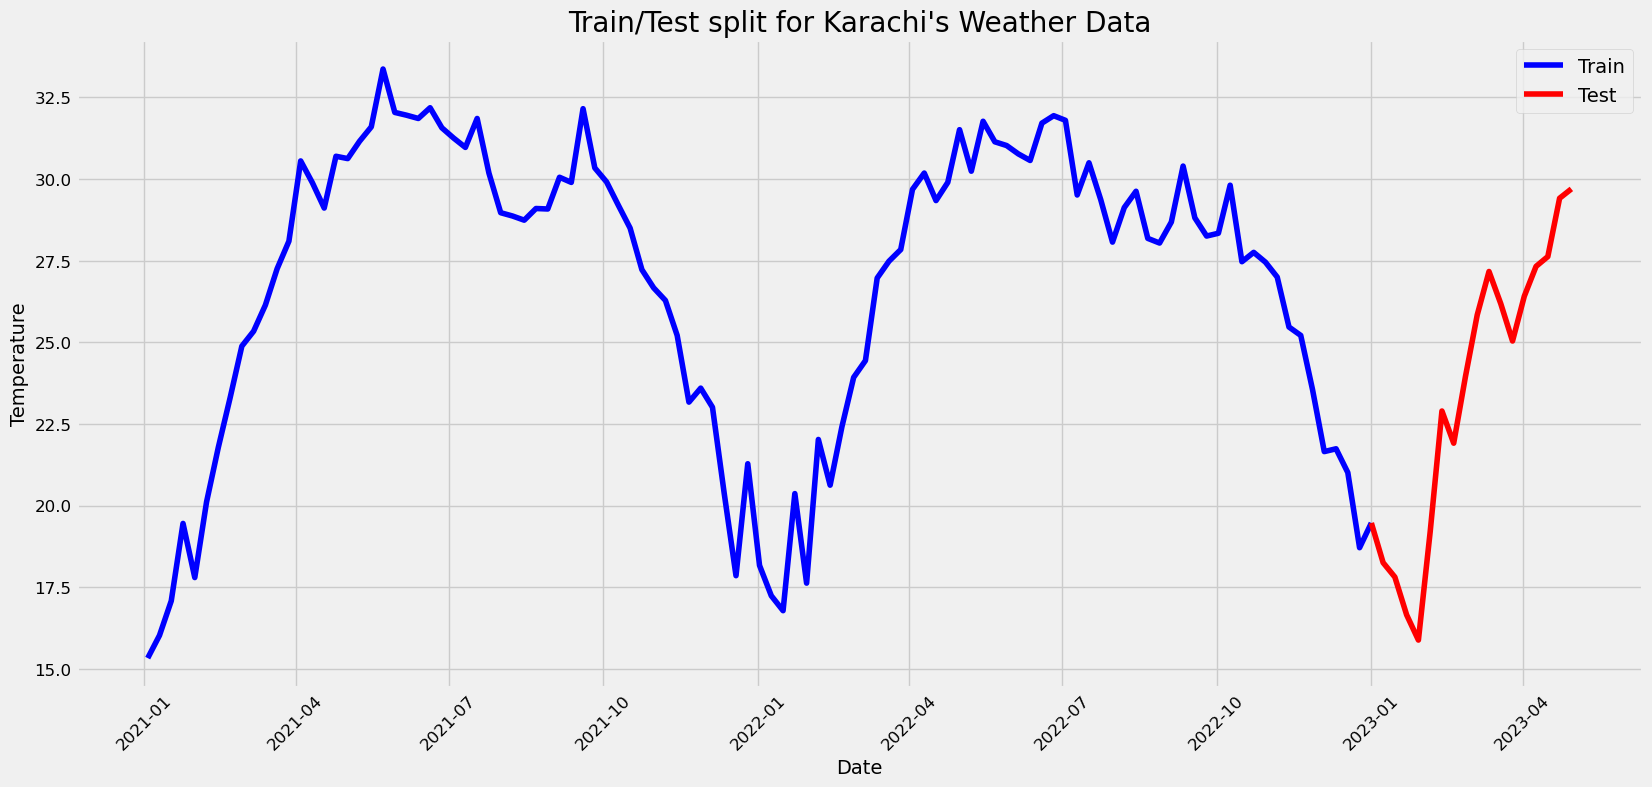

In [22]:
#Question 3

train_set = weekly_mean[weekly_mean.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test_set = weekly_mean[weekly_mean.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]

plt.plot(train_set, color = "blue", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')

plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Karachi's Weather Data")
plt.legend()
plt.show()

# In the depicted graph, the data has been divided into training and testing sets.
# The black portion corresponds to the training data, while the red portion represents the testing data.
# The x-axis denotes the date, and the y-axis indicates the dependent variable,
# which in this case is temperature.

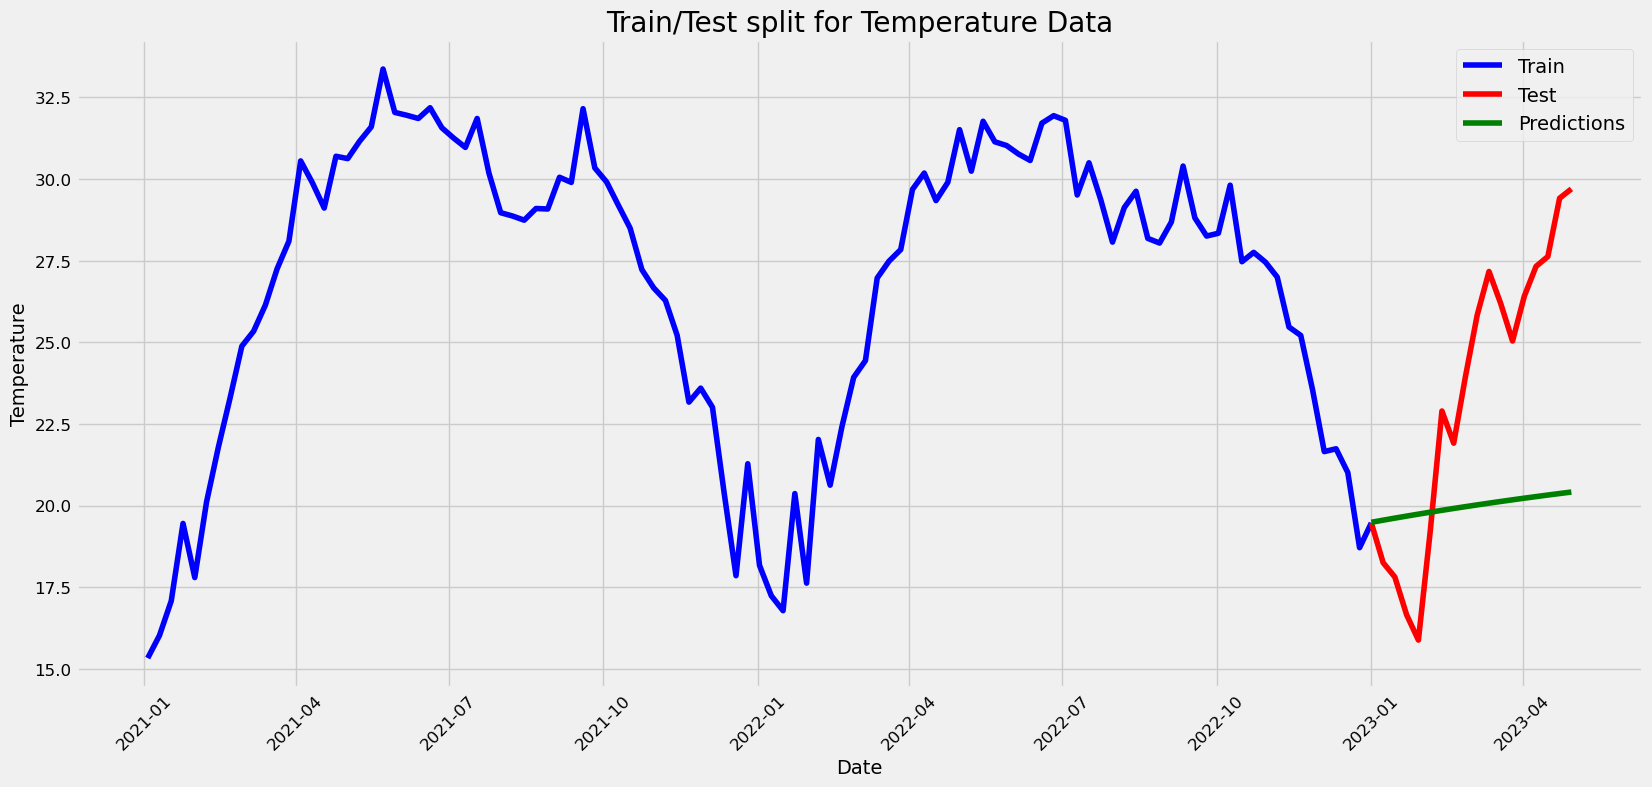

RMSE:  5.333699292466581


In [23]:
#Question 4

ARIMAmodel = ARIMA(train_set, order = (1, 0, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test_set.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for plotting 
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train_set, color = "blue", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_set.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [24]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  105
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -185.835
Date:                Sun, 26 Nov 2023   AIC                            379.669
Time:                        17:13:56   BIC                            390.285
Sample:                    01-03-2021   HQIC                           383.971
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4693      3.881      5.790      0.000      14.863      30.075
ar.L1          0.9783      0.024     39.979      0.000       0.930       1.026
ma.L1         -0.1032      0.089     -1.163      0.2

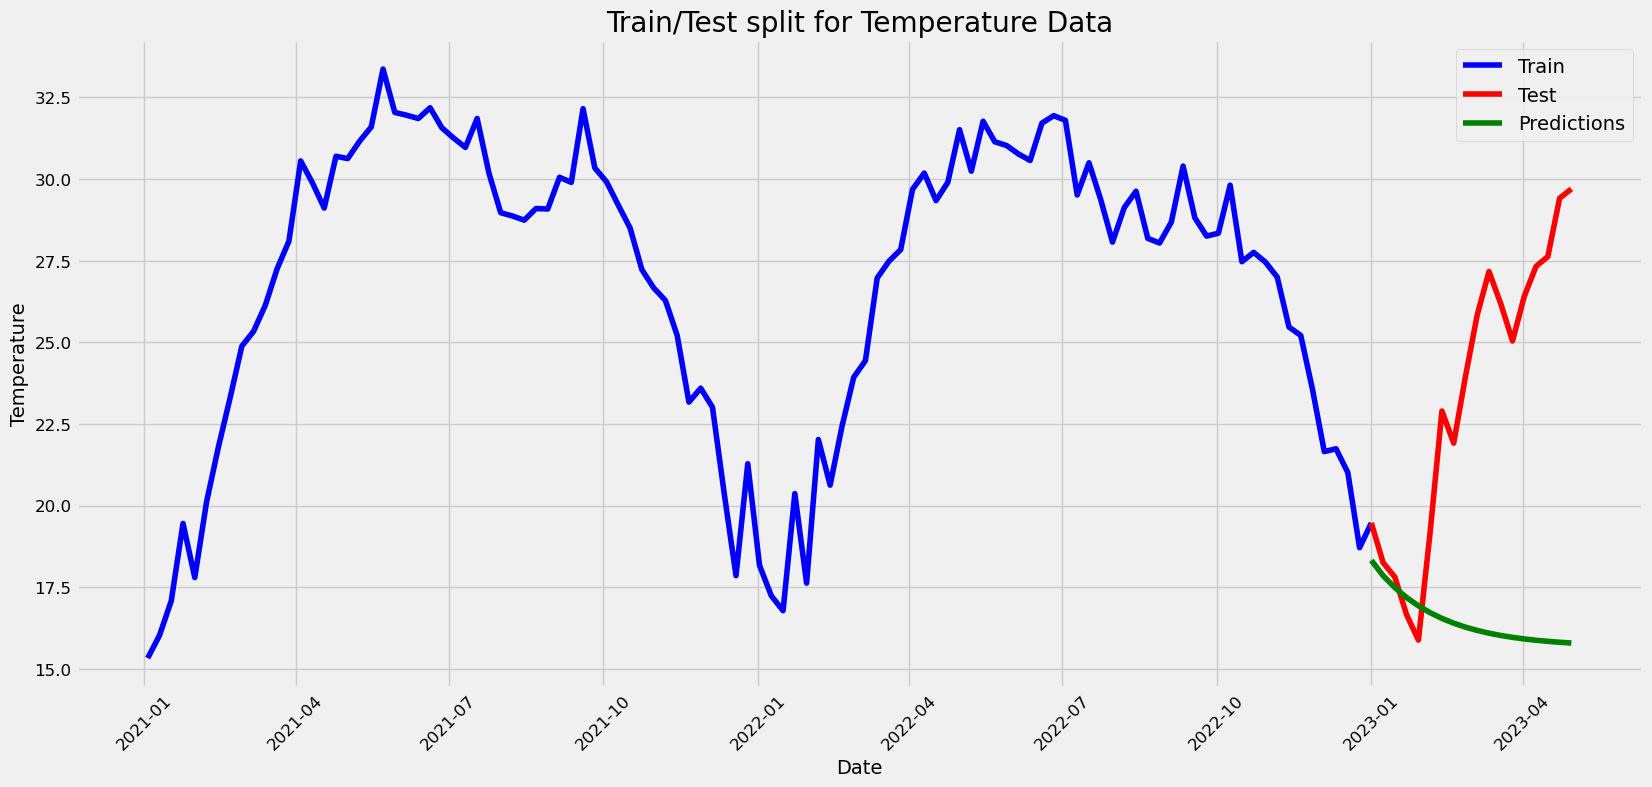

RMSE:  8.493311525437383


In [25]:
ARIMAmodel = ARIMA(train_set, order = (2, 1, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test_set.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for plotting 
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train_set, color = "blue", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_set.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [26]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  105
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -168.978
Date:                Sun, 26 Nov 2023   AIC                            347.957
Time:                        17:13:57   BIC                            361.179
Sample:                    01-03-2021   HQIC                           353.314
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8786      0.199      4.426      0.000       0.489       1.268
ar.L2         -0.0388      0.205     -0.189      0.850      -0.440       0.362
ma.L1         -1.2279      0.154     -7.970      0.0

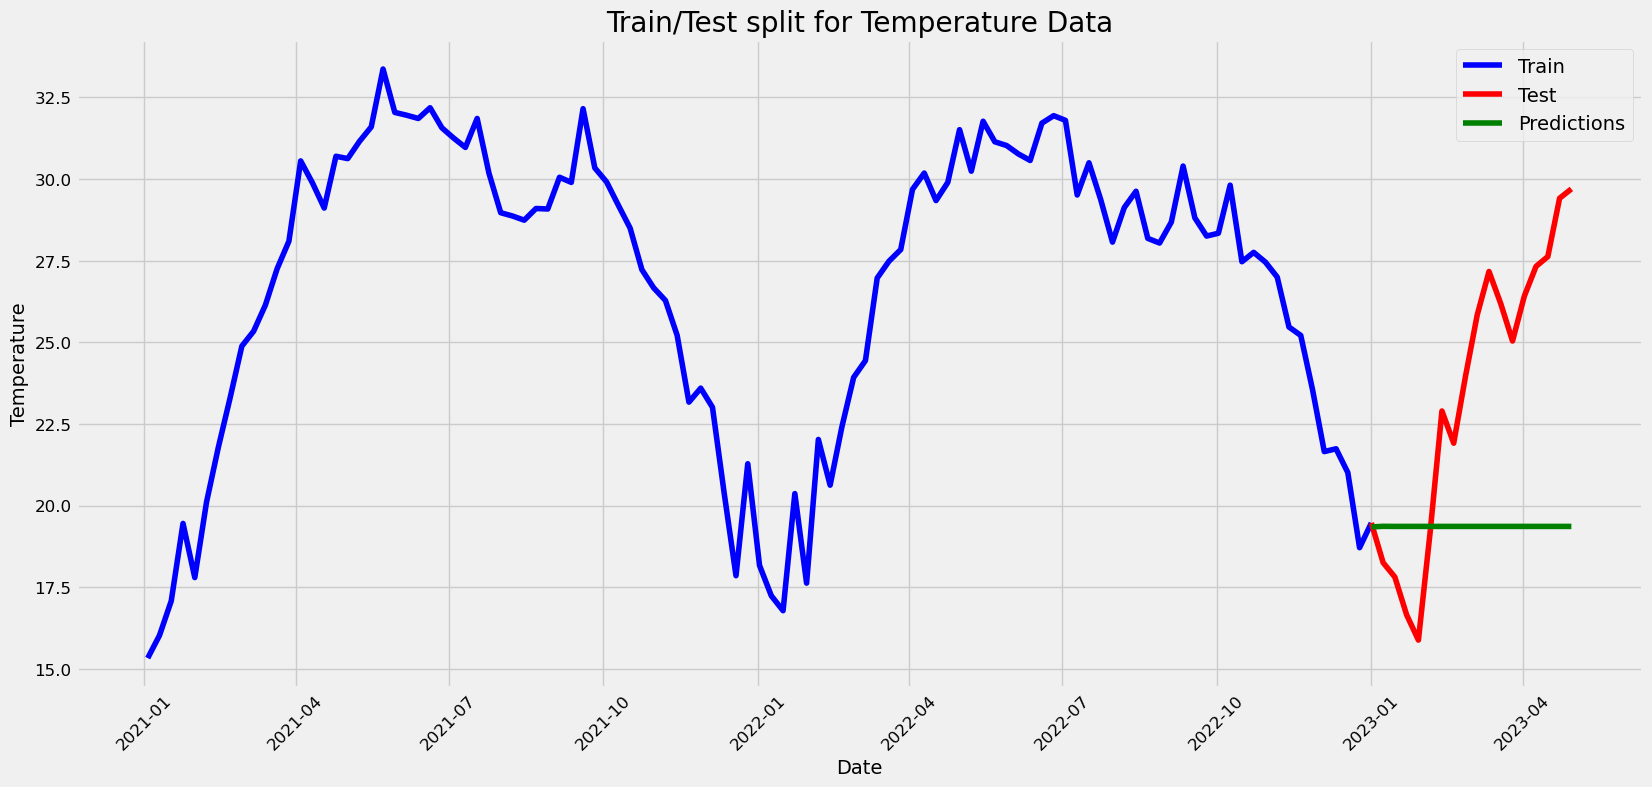

RMSE:  5.934271555324831


In [27]:
ARIMAmodel = ARIMA(train_set, order = (1, 1, 0))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test_set.index)) #only providing dates (test.index) from test as input for forecasting
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

#for plotting 
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train_set, color = "blue", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_set.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [28]:
print(ARIMAmodel.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  105
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -182.796
Date:                Sun, 26 Nov 2023   AIC                            369.592
Time:                        17:13:57   BIC                            374.881
Sample:                    01-03-2021   HQIC                           371.735
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1613      0.083     -1.944      0.052      -0.324       0.001
sigma2         1.9683      0.289      6.803      0.000       1.401       2.535
Ljung-Box (L1) (Q):                   0.09   Jarque-

In [29]:
# Based on the provided graphs and RMSE values, the most effective ARIMA model is
# the one with the order (1, 0, 1), showcasing the lowest RMSE of 5.334.

# Another competitive model is the (2, 1, 2) order, yielding a respectable RMSE of 8.493.
# However, this model involves differencing the time series once, potentially leading to information loss.

# Moreover, the (1, 1, 0) order model exhibits a lower RMSE of 5.934, indicating
# it may potentially be suitable for accurate forecasting.

# In the context of the ARIMA model, an RMSE value of 5.33 implies that, on average,
# the model's predictions deviate from the actual values by approximately 5.33 units.
# A lower RMSE signifies more accurate predictions, closely aligning with the actual values,
# while a higher RMSE indicates less accuracy and a greater deviation from the actual values.
# Hence, (1, 0, 1) is the most accurate combination in the above.

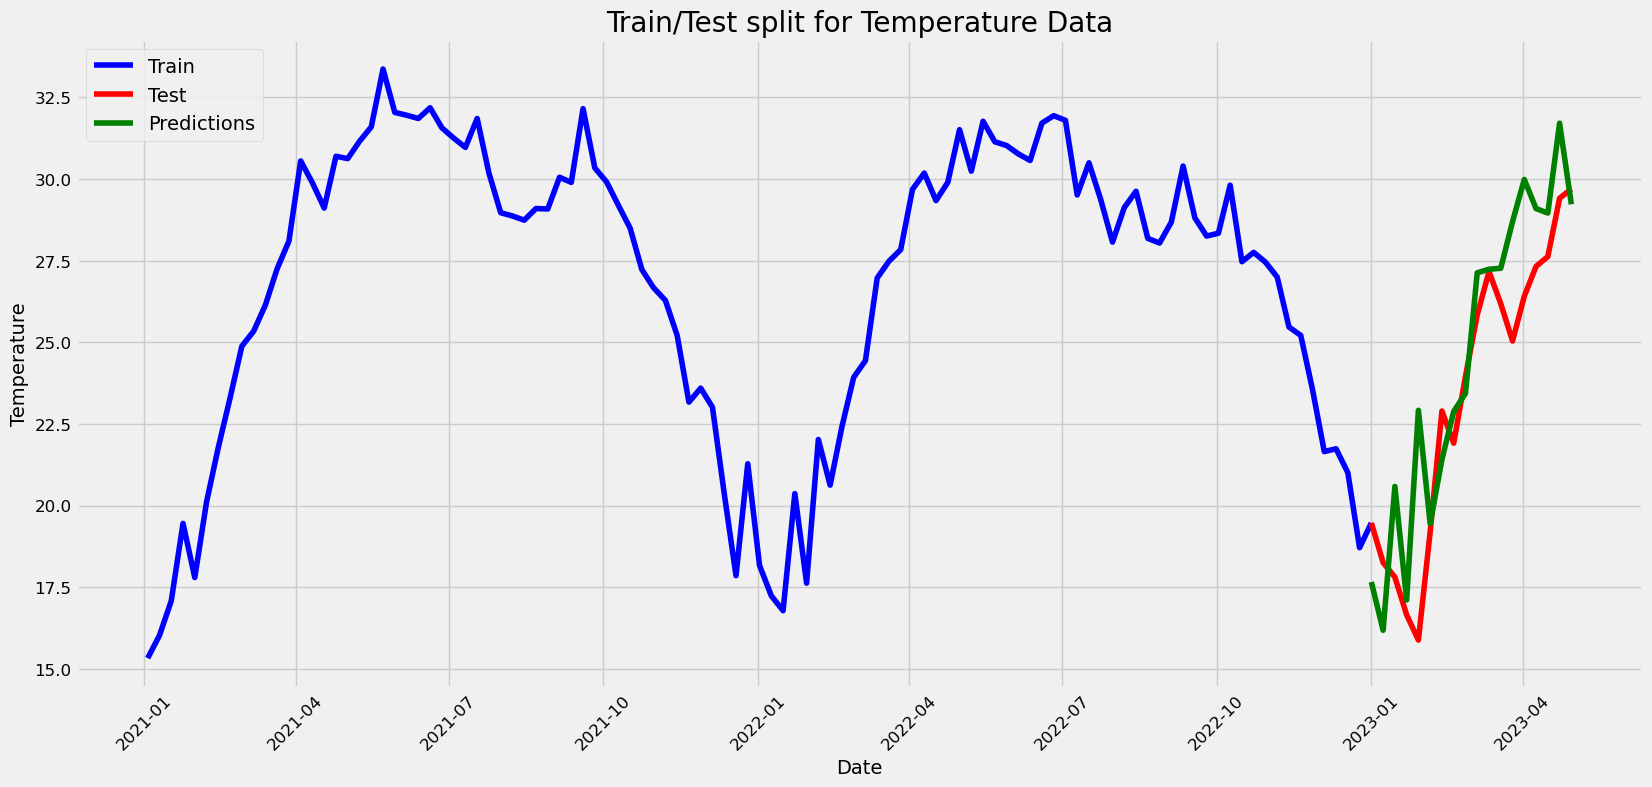

RMSE:  2.447712089394363


In [30]:
#Question 5

SARIMAXmodel = SARIMAX(train_set,order=(0, 1, 1),seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test_set.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train_set, color = "blue", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temperature Data")

plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_set.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [31]:
print(SARIMAXmodel.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                 -87.453
Date:                            Sun, 26 Nov 2023   AIC                            182.907
Time:                                    17:14:00   BIC                            190.712
Sample:                                01-03-2021   HQIC                           185.899
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8381      0.088     -9.512      0.000      -1.011      -0.665
ar.S.L52       0.4630   5.03e+04   

In [32]:
# In our analysis, we incorporated all the essential components of the ARIMA model,
# including the Trend autoregression order, trend difference order, and trend moving
# average order. However, for the trend season orders, we focused solely on the
# autoregressive order and difference order.

# Upon visual inspection of the plot, it is evident that the SARIMA model adeptly captured
# the overall trend and seasonality of the temperature data, effectively accommodating
# fluctuations and noise in the dataset. This is manifested in the close tracking of the
# green line with the red line across most regions of the plot.

# The root mean square error (RMSE) value for the SARIMA model, applied to the weather
# dataset, was computed as 2.44. This indicates that, on average, the model's predictions
# deviated from the actual temperature values by approximately 2.44 units. A lower RMSE
# value implies greater accuracy and closer alignment of the model's predictions with the
# actual values. Consequently, this suggests that the SARIMA model proficiently captures
# the patterns and fluctuations in temperature data, establishing itself as a valuable tool
# for predicting future temperature values.

In [33]:
#Question 6

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [34]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(train_set,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:984.8420684895565
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:794.8740753564534
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:607.5559163040926
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:484.26129484164653
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:618.3647982926848
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:579.2381552677981
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:519.5308452383847
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:494.7578185183568
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:849.108241492213
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:678.1478903092263
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:515.6741383132564
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:414.71272233672204
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:536.2241434873929
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:494.8123617075188
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:451.89891297079197
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:416.71264646218145
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:367.5640576142285
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:323.52568636255825
ARIMA(

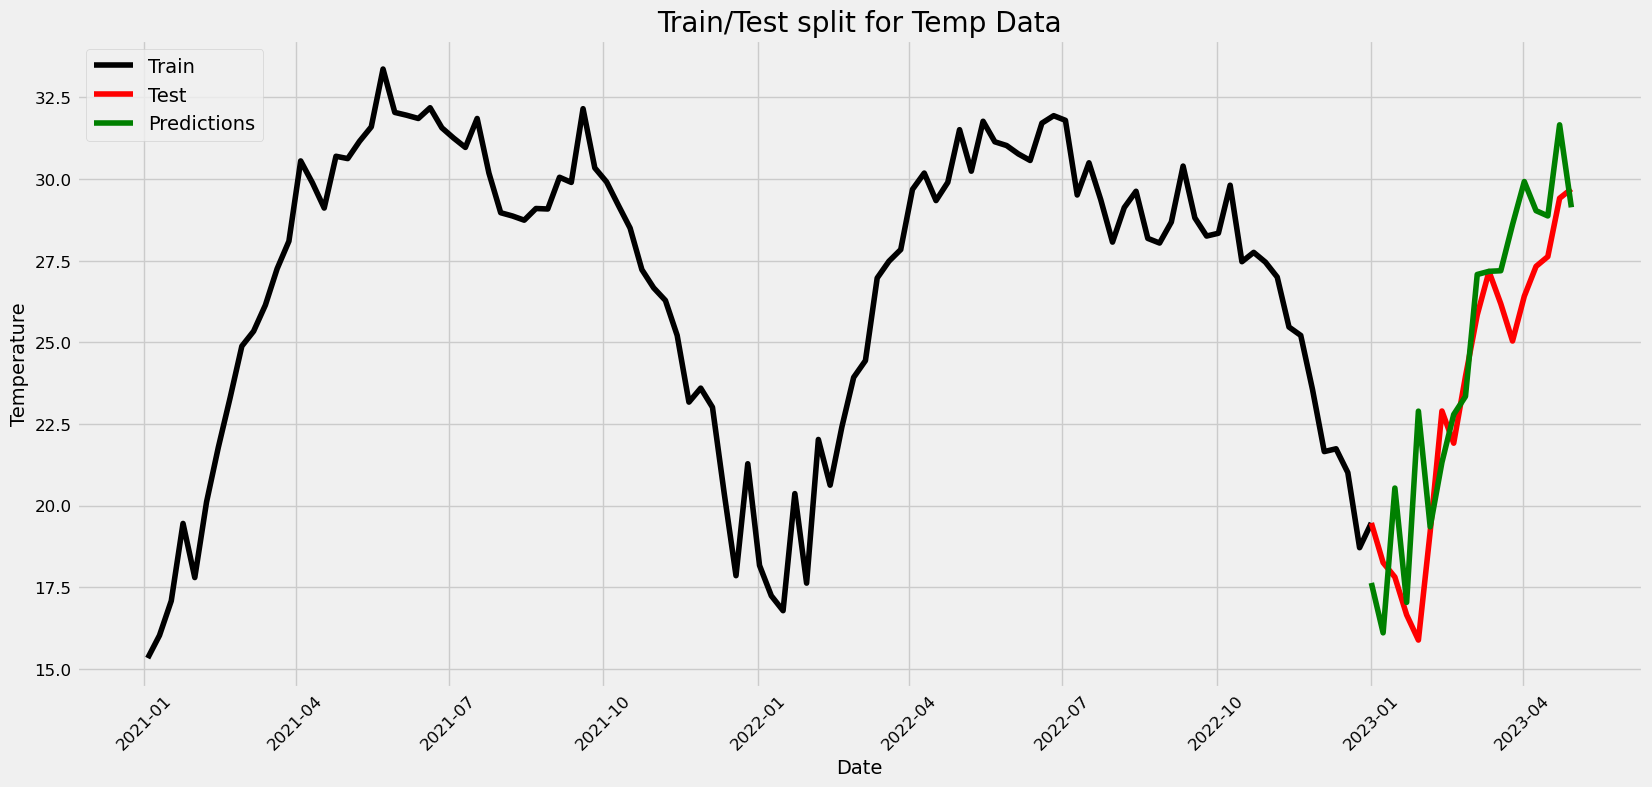

RMSE:  2.424172625200149


In [35]:
SARIMAXmodel = SARIMAX(train_set,order=(1, 1, 1),seasonal_order=(1, 1, 1, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test_set.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test_set.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train_set, color = "black", label = 'Train')
plt.plot(test_set, color = "red", label = 'Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Temp Data")

plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

arma_rmse = np.sqrt(mean_squared_error(test_set.values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [36]:
# The recently optimized parameter values for the SARIMA model produced results
# nearly identical to those of the prior SARIMAX model, yielding an RMSE of 2.424.
# The only modification involves the inclusion of the moving average order, but its
# impact on predictions for the given dataset is minimal.

# Upon comparing the performance of both the ARIMA and SARIMA models on the dataset,
# it becomes apparent that the SARIMA model outperforms the ARIMA model. This
# conclusion is supported by the significantly lower RMSE value associated with the
# SARIMA model. A reduced RMSE value signifies more precise predictions, a fact
# substantiated by the graphical representation where the green line (predictions)
# closely aligns with the red line (test) when utilizing the SARIMA model, in contrast
# to the ARIMA model. Consequently, it can be inferred that the SARIMA model is better
# suited for the temperature data and is capable of providing more accurate temperature predictions.

In [37]:
#Question 7

#extracting the seasonality data
months = [x.month for x in train_set.index]
years = [x.year for x in train_set.index]
day = [x.day for x in train_set.index]
 
#converting into one matrix
trainX = np.array([day, months, years]).T
trainY = train_set.values

#extracting the day, month and year data
tmonths = [x.month for x in test_set.index]
tyears = [x.year for x in test_set.index]
tday = [x.day for x in test_set.index]
 
#converting into one matrix
testX = np.array([tday, tmonths, tyears]).T
testY = test_set.values

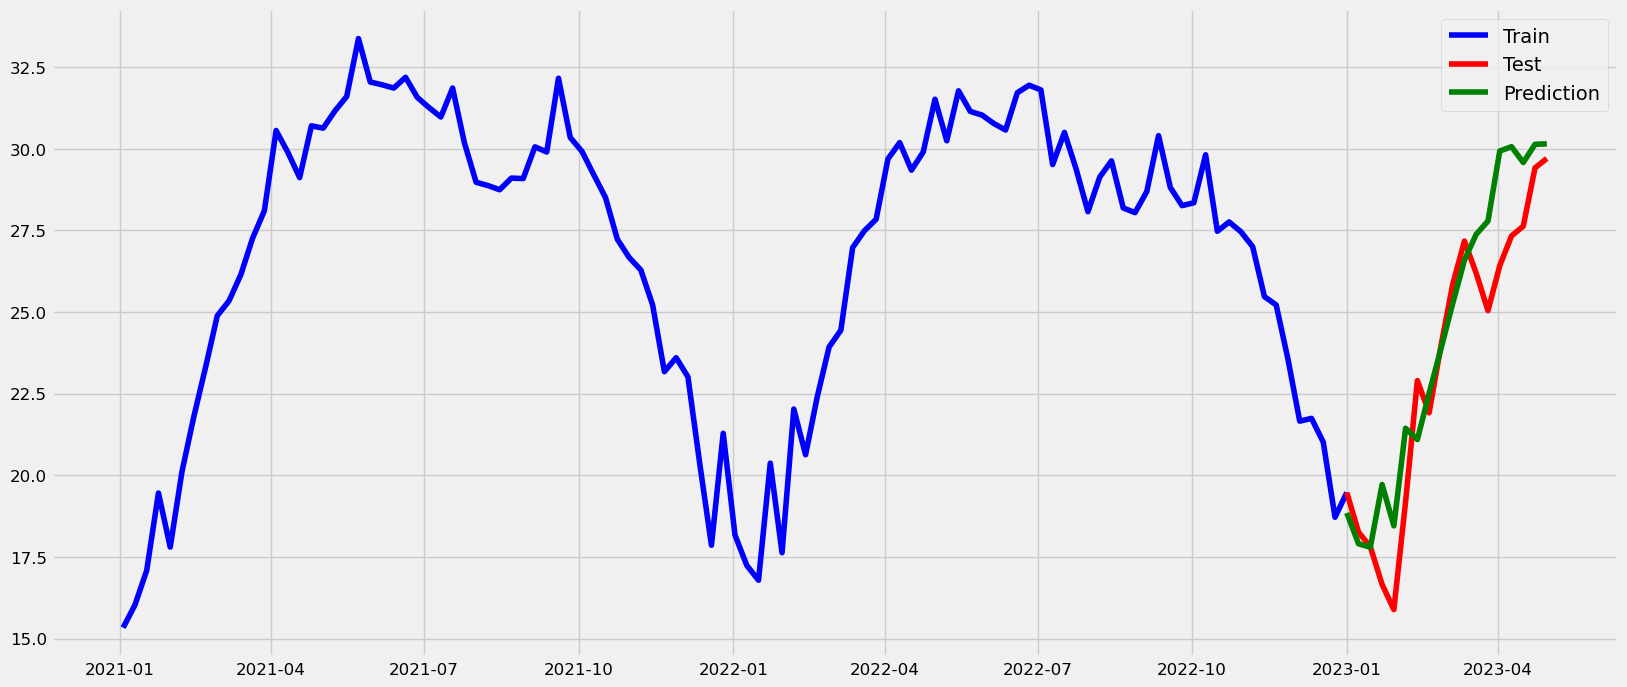

RMSE:  1.8116366890735323


In [38]:
#Using the Random Forest Regression

# fit the model
rfmodel = RandomForestRegressor()
rfmodel.fit(trainX,trainY)
 
# predict on the same period
preds = rfmodel.predict(testX)
 
# plot what has been learned
plt.plot(train_set.index, train_set.values,color="blue", label='Train')
plt.plot(test_set.index, test_set.values,color="red", label='Test')
plt.plot(test_set.index, preds, color="green",label='Prediction')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(test_set.values, preds))
print("RMSE: ",rf_rmse)

In [39]:
# The RMSE value of 1.80 signifies an average deviation of 1.80 units between the predicted
# values and the actual test values. This alignment is visually evident in the model
# representation, where the predicted values (depicted by the green line) closely match
# the actual test values (depicted by the red line). This alignment serves as an indication
# that the regression model is performing effectively, generating accurate predictions.

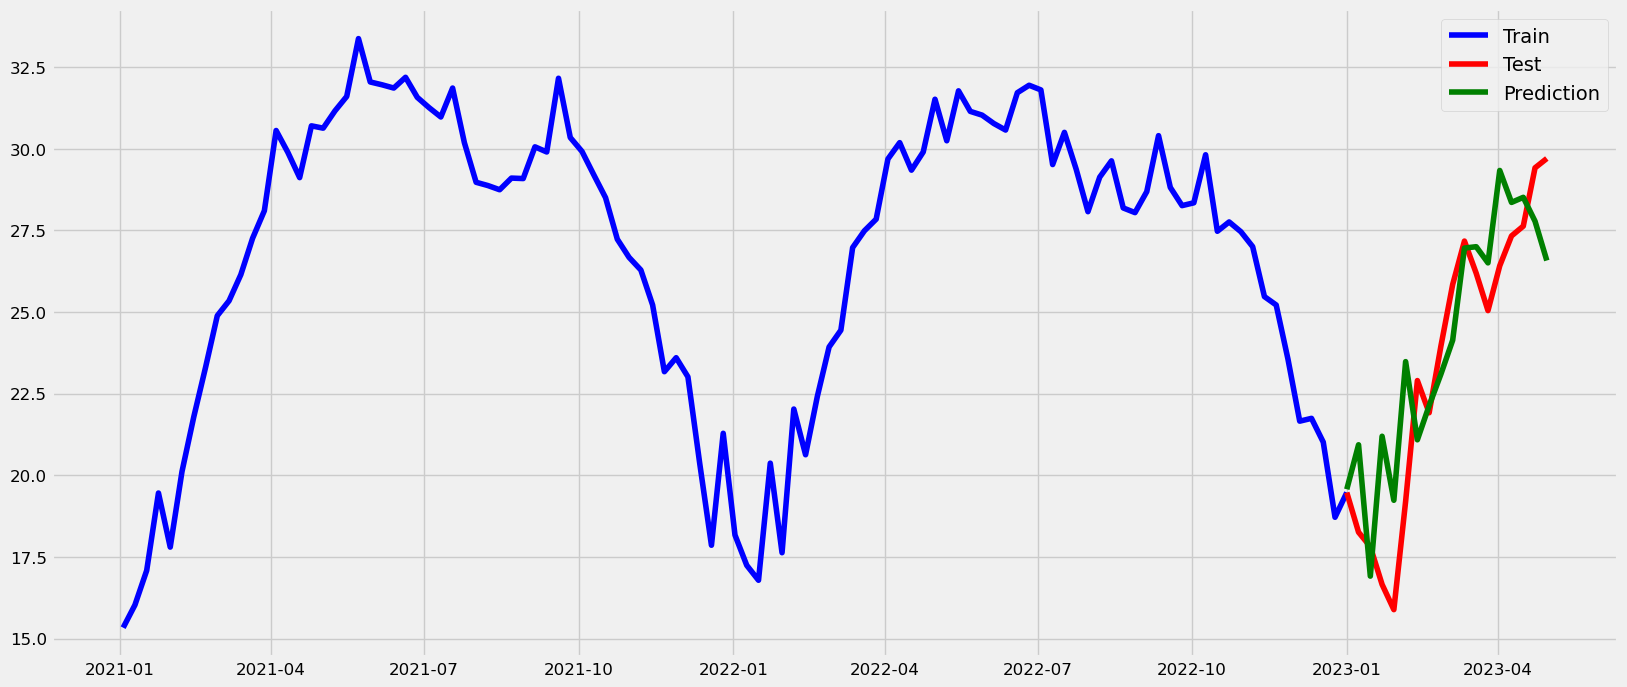

RMSE:  2.2452497576659773


In [40]:
#Using Support Vector Regression

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr.fit(trainX, trainY)

preds = svr.predict(testX)

#plotting what has been learned
plt.plot(train_set.index, train_set.values,color="blue", label='Train')
plt.plot(test_set.index, test_set.values,color="red", label='Test')
plt.plot(test_set.index, preds, color="green",label='Prediction')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(test_set.values, preds))
print("RMSE: ",rf_rmse)

In [41]:
# The RMSE value of 2.25 indicates an average deviation of 2.35 units between the predicted
# values and the actual test values. The visual depiction of the model highlights some
# disparities between the predicted and actual values at the start and end of the test dataset.
# However, in the middle of the dataset, the predicted and actual values exhibit good alignment.
# Given that the differences in the middle of the dataset do not substantially contribute to the
# RMSE, we can assert that the model demonstrates overall satisfactory performance.

In [42]:
#Question 8

# In this scenario, the Support Vector regression model exhibits one of the lowest RMSE value of 2.245, surpassing both ARIMA, SARIMA, and itself.
# The Random Forest regression model achieves an even lower RMSE value of 1.803, outperforming the Support Vector model.
# The SARIMA model registers an RMSE value of 2.447, while ARIMA records the highest RMSE value at 5.333, indicating the least accurate predictions among the models.

# Considering the RMSE values for ARIMA, SARIMA, Random Forest, and Support Vector regression algorithms,
# it can be inferred that the Random Forest regressor performs the best among the techniques employed.
# Its RMSE value is the lowest compared to the other three regression models.
# Additionally, visualized results demonstrate a strong alignment between predicted and test values across the entire dataset,
# making it a suitable fit for the given weather dataset.
# SARIMA and Support Vector models report nearly identical RMSE values, suggesting either could be employed.
# The ARIMA model fares the poorest among the four, with a significantly higher RMSE value than the other three,
# and visualized results indicating substantial deviations between predicted and test values.

# Therefore, based on RMSE values, the Random Forest and Support Vector models emerge as superior choices for this dataset,
# while the ARIMA model performs the least effectively.
# However, it's essential to consider other factors like computational complexity and interpretability
# when selecting the most suitable model for a specific use case.

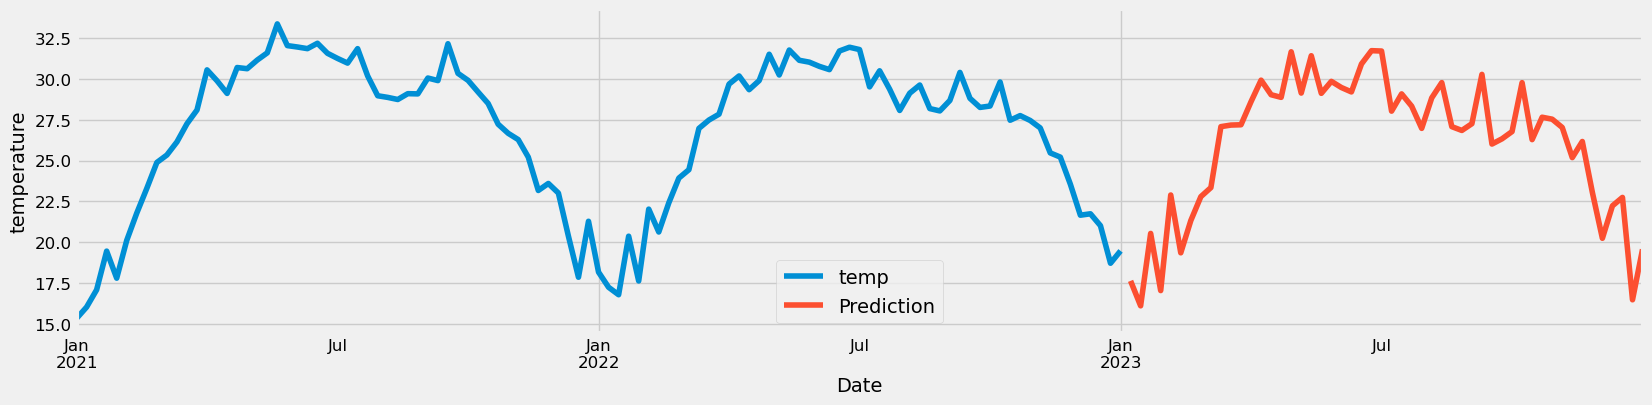

In [43]:
#Question 9

start_date = '01/04/2023'
end_date = '31/12/2023'
future_dates = pd.date_range(start=start_date, end=end_date, freq='W')

train = weekly_mean[weekly_mean.index <= pd.to_datetime("2023-04-01", format='%Y-%m-%d')]

#Defining the SARIMA model with optimal parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 52) # 52 weeks in a year
SARIMAXmodel = SARIMAX(train_set, order=order, seasonal_order=seasonal_order)

#Fitting the model to the training data
SARIMAXfit = SARIMAXmodel.fit()

#Generating predictions for the future dates
pred_u = SARIMAXfit.get_forecast(steps=len(future_dates))
pred_c = pred_u.conf_int()

#Plotting the observed data and the forecast
ax = train_set.plot(label='Observed', figsize=(18, 4))
pred_u.predicted_mean.plot(ax=ax, label='Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('temperature')
plt.legend()
plt.show()

In [44]:
# This graph illustrates the correlation between date and temperature for both observed and forecasted data.
# The Orange line in the graph represents the forecasted data, displaying a strikingly similar pattern to the blue line,
# which represents the observed data. This graph serves as the basis for the forecasted data.

In [45]:
#Question 10

pred_mean = pred_u.predicted_mean
forecast_da = pd.DataFrame({'date': future_dates, 'temp_Pre': pred_mean.values,})

#Setting the index to the date column
forecast_da.set_index('date', inplace=True)
Res = forecast_da[forecast_da.index >= pd.to_datetime("2023-04-01", format='%Y-%m-%d')]
Res

,temp_Pre
date,
2023-04-02,28.609261
2023-04-09,29.926264
2023-04-16,29.033590
2023-04-23,28.873364
2023-04-30,31.663337
2023-05-07,29.136514
2023-05-14,31.422308
2023-05-21,29.119876
2023-05-28,29.852485


In [46]:
#extracting the seasonality data
months = [x.month for x in train_set.index]
years = [x.year for x in train_set.index]
day = [x.day for x in train_set.index]
 
#converting into one matrix
trainX2 = np.array([day, months, years]).T
trainY2 = train_set.values

# extract the day, month and year data
tmonths = [x.month for x in test_set.index]
tyears = [x.year for x in test_set.index]
tday = [x.day for x in test_set.index]
 
# convert into one matrix
testX2 = np.array([tday, tmonths, tyears]).T
testY2 = test_set.values

In [47]:
#Random Forest Regression Model

rfmodel = RandomForestRegressor()
rfmodel.fit(trainX2,trainY2)

pred = rfmodel.predict(testX2)
pred = pd.Series(pred)
pred

0     18.924667
1     17.841381
2     17.774857
3     19.679000
4     18.324286
5     21.706571
6     21.174571
7     22.540714
8     23.957143
9     25.225571
10    26.489286
11    27.335000
12    27.848857
13    29.960429
14    30.081571
15    29.631143
16    29.905429
17    29.972857
dtype: float64

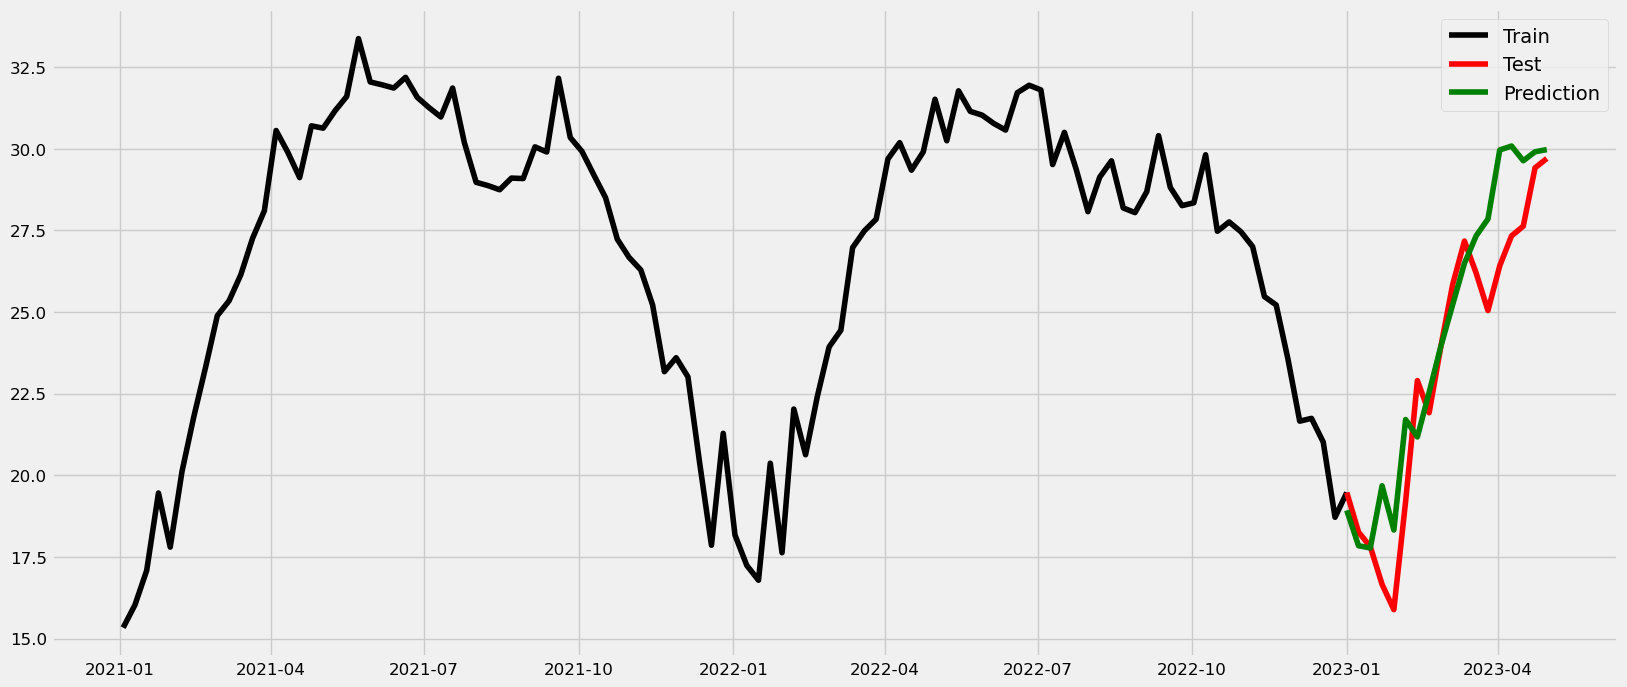

RMSE:  2.2452497576659773


In [48]:
#Question 11

plt.plot(train_set.index, train_set.values,color="black", label='Train')
plt.plot(test_set.index, test_set.values,color="red", label='Test')
plt.plot(test_set.index, pred, color="green",label='Prediction')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(test_set.values, preds))
print("RMSE: ",rf_rmse)

In [49]:
# The root mean square error (RMSE) of 2.245 indicates a difference of 2.245 units between predicted and forecasted values.
# This difference surpasses the RMSE observed when using the Random Forest Regressor on the previous test dataset from the original dataset.
# Therefore, it can be deduced that although the Random Forest Regressor performed well on the original dataset,
# its effectiveness may slighly diminish when applied to the forecasted dataset.